In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix

%matplotlib inline

Loading the dataset and provided header file

In [2]:
field_names = None
with open('field_names.txt','r') as f:
    field_names = f.read().split('\n')
cancer_df = pd.read_csv('breast-cancer.csv',names=field_names)

In [3]:
cancer_df[['radius_mean','smoothness_mean','compactness_mean','radius_sd_error','texture_sd_error','perimeter_mean',
                         'perimeter_worst','area_mean','area_worst','concavity_mean','fractal_dimension_sd_error']].to_csv('test.csv',index=False)

Display general information about the dataset, including the columns and the datatypes of each. Using the information below, I would perform the following evaluations and transformations on the dataset:
* Check for missing values. In the case there's missing values in the dataset, I would either omit the records containing the missing value from the dataset (but only if the missing values are in a very tiny percentage of records) or attempt to impute the missing values by using the mean, or K Nearest Neighbors algorithm.
* Check for outliers. Inspect the values of each column for unusual values, either correcting the values if it's incorrect, or excluding the affected records from the analysis.
* Check for duplicate records in the dataset, and remove them
* Check for improperly formatted text, and correct them.

In [4]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
ID                            569 non-null int64
diagnosis                     569 non-null object
radius_mean                   569 non-null float64
radius_sd_error               569 non-null float64
radius_worst                  569 non-null float64
texture_mean                  569 non-null float64
texture_sd_error              569 non-null float64
texture_worst                 569 non-null float64
perimeter_mean                569 non-null float64
perimeter_sd_error            569 non-null float64
perimeter_worst               569 non-null float64
area_mean                     569 non-null float64
area_sd_error                 569 non-null float64
area_worst                    569 non-null float64
smoothness_mean               569 non-null float64
smoothness_sd_error           569 non-null float64
smoothness_worst              569 non-null float64
compactness_mean              5

Inspect the first few records in the dataset

In [5]:
cancer_df.head()

,ID,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Check the distribution of the target variable.

In [6]:
cancer_df.diagnosis.value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

We have an unbalanced dataset, which means we'll need to evaluate the performance of the models we'll be building using a metric other than accuracy. For this exercise we'll be using the F1 score to evaluate the model performance. 

Computing the mean and median smoothness and compactness for benign and malignant tumors. Let's determine if there's a difference between the measurements among benign and malignant tumors.

In [7]:
cancer_df.groupby('diagnosis')[['smoothness_mean','compactness_mean']].agg(['mean','median'])

smoothness_mean         compactness_mean         
                     mean  median             mean   median
diagnosis                                                  
B                2.000321  1.8510         0.021438  0.01631
M                4.323929  3.6795         0.032281  0.02859

Looking at the results, there definitely appears to be a difference among both groups. We can use a statistical test to verify this.

In [8]:
def run_statistical_test(df, num_col):
    """
    Run a standard two sample t test on dataset
    
    Input:
        df      - cancer dataset as a pandas dataframe
        num_col - name of the numeric column to use for the test
    
    Return:
        the p value of the test
    """
    benign = df[df.diagnosis == 'B'][num_col]
    malignant = df[df.diagnosis == 'M'][num_col]
    
    return ttest_ind(benign, malignant)[1]

In [9]:
smoothness_pvalue = run_statistical_test(cancer_df, 'smoothness_mean')
compactness_pvalue = run_statistical_test(cancer_df, 'compactness_mean')
print('Smoothness Mean p_value {0}'.format(smoothness_pvalue))
print('Compactness Mean p_value {0}'.format(compactness_pvalue))

Smoothness Mean p_value 1.6519051758498057e-47
Compactness Mean p_value 9.975994654074587e-13


Compute correlations between every numeric column in the dataset

In [10]:
correlations = cancer_df[field_names[2:]].corr()

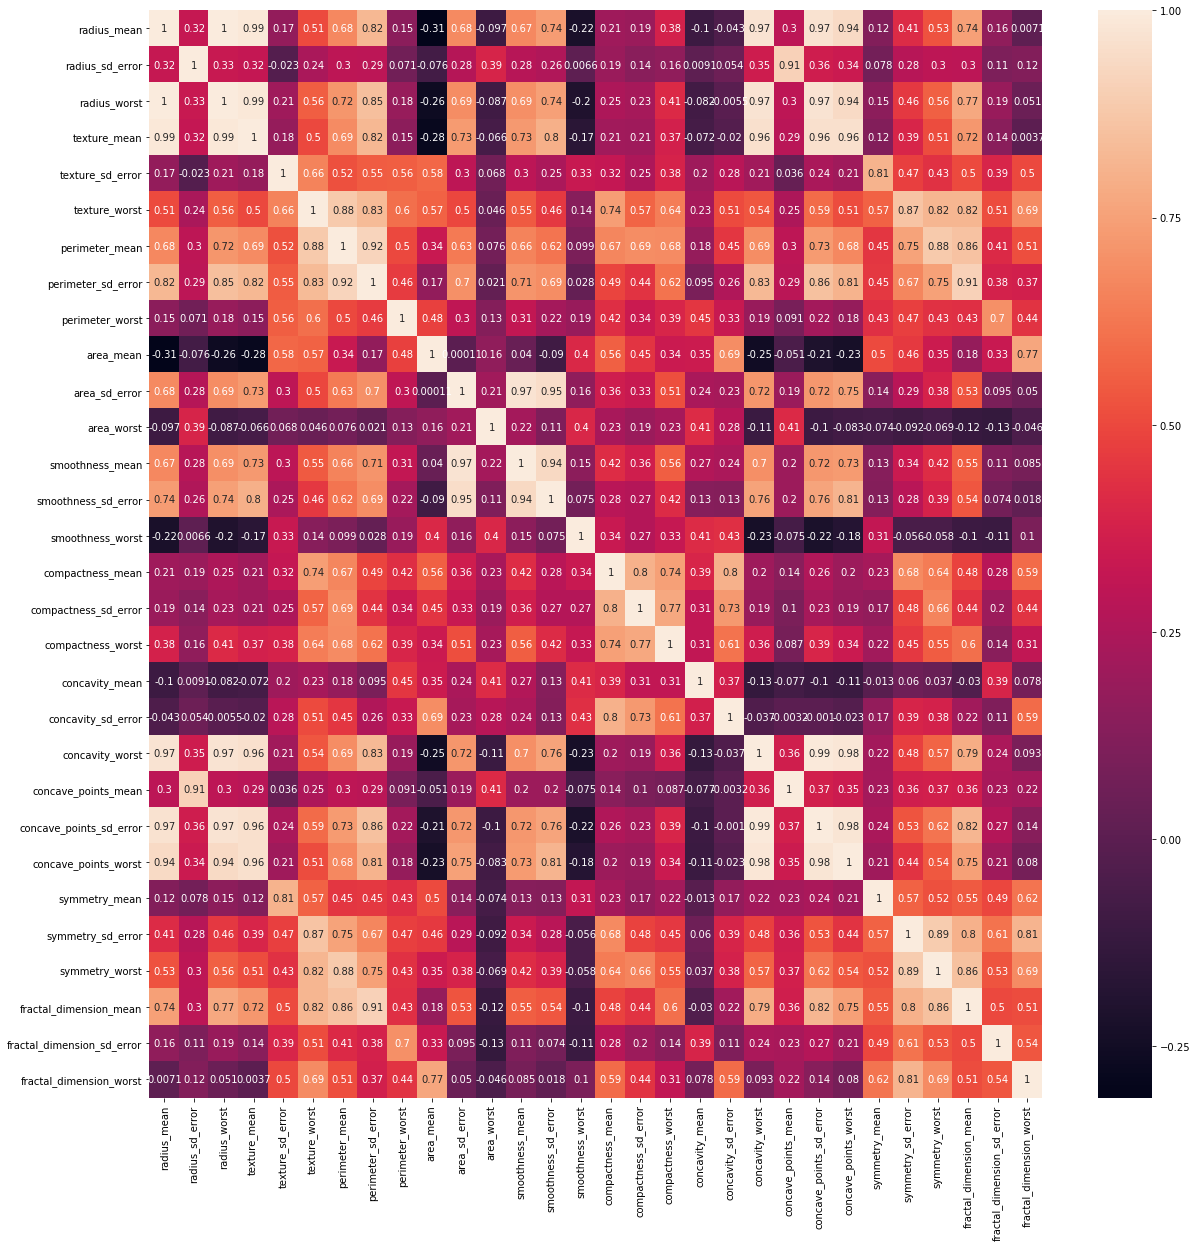

In [11]:
plt.figure(figsize=(20,20))
sbn.heatmap(correlations, annot=True);

Heatmap suggests multiple cases of multicollinearity among the columns in the dataset. Creating scatterplots of data to verify the correlations.

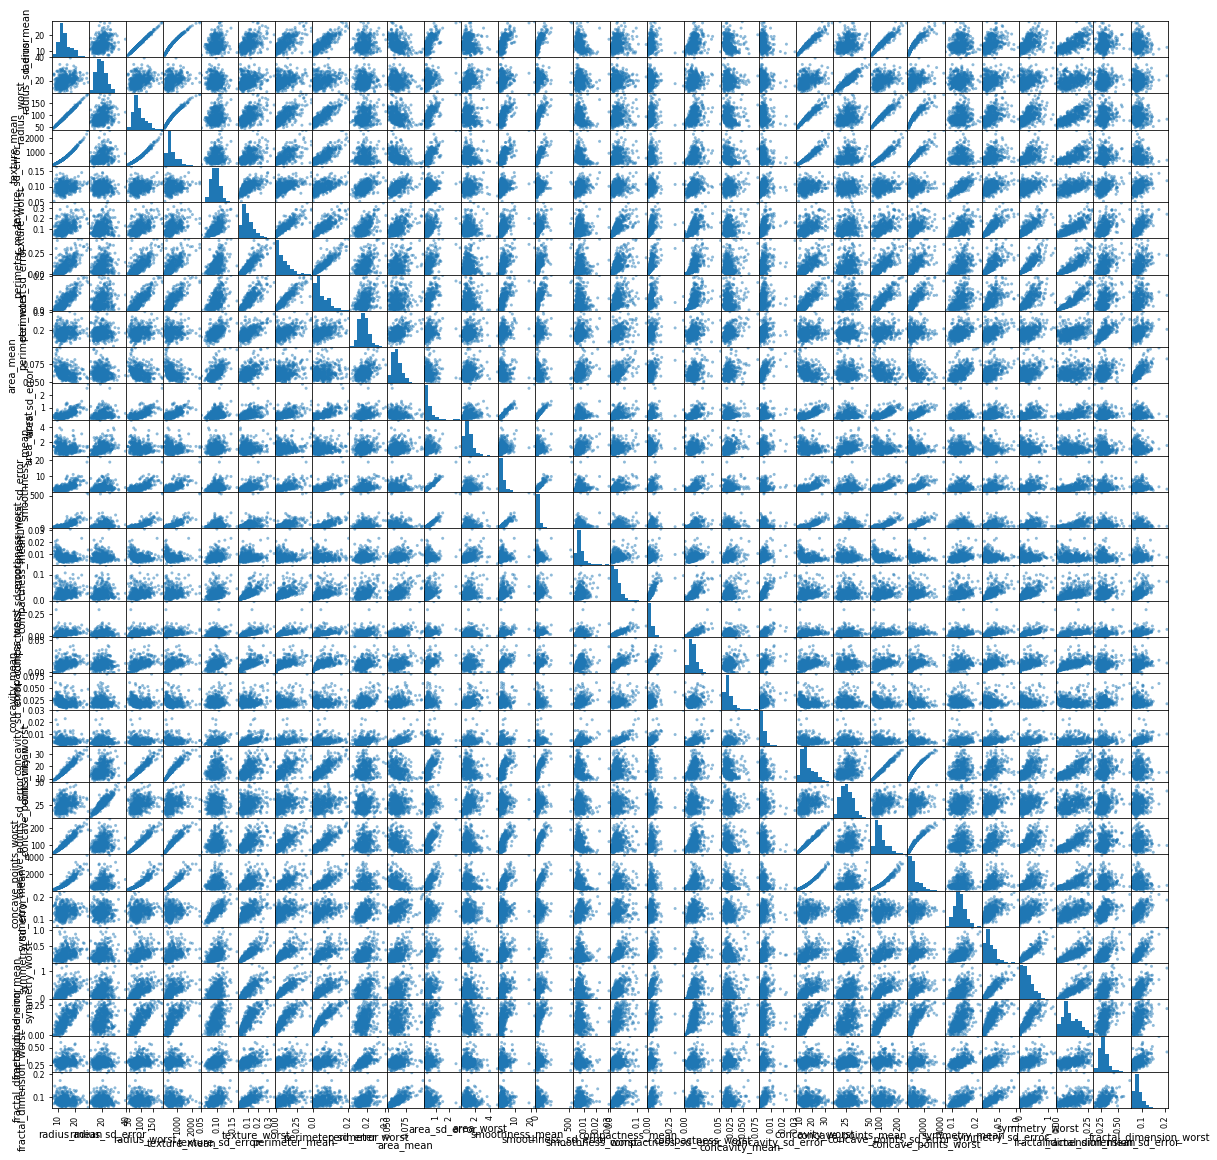

In [12]:
pd.plotting.scatter_matrix(cancer_df[field_names[2:]], figsize=(20,20));

The above scatterplot confirms that there's multicollinearity in the data. Using the information, I've reduced the number of variables under consideration to 11. These are:
* radius_mean
* smoothness_mean
* compactness_mean
* radius_sd_error
* texture_sd_error
* perimeter_mean
* perimeter_worst
* area_mean
* area_worst
* concavity_mean
* fractal_dimension_sd_error

I've also identified three variables that are highly predictive of malignant tumors. These are:
* radius_mean
* smoothness_mean
* perimeter_mean

In [13]:
def plot_distribution(data, num_col, ax):
    sbn.distplot(data[data.diagnosis == 'B'][num_col], label='Benign', ax=ax)
    sbn.distplot(data[data.diagnosis == 'M'][num_col], label='Malignant', ax=ax)
    ax.set_title(num_col)
    ax.legend()

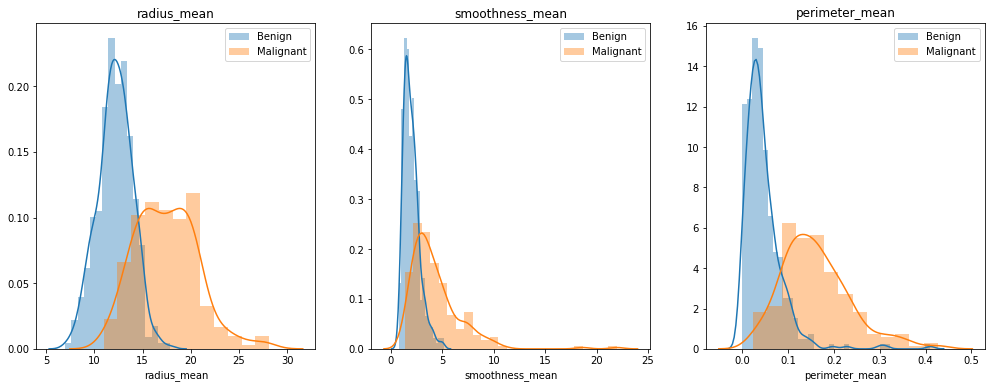

In [14]:
fig, axes= plt.subplots(1, 3, figsize=(17,6))
plot_distribution(cancer_df, 'radius_mean', axes[0]);
plot_distribution(cancer_df, 'smoothness_mean', axes[1]);
plot_distribution(cancer_df, 'perimeter_mean', axes[2]);

As shown above, malignant tumors on average have a significantly larger radius, smoothness, and perimeter than benign tumors. In addition to this, the overlaps in the measurements between benign and malignant tumors are smaller compared to other variables in the dataset, which is a strong indicator of high predictability.

### Modeling

Fitting several models using the variables identified in the last section. For the sake of time, I am reframing from doing extensive hyper parameter tuning of the model parameters.

In [15]:
selected_features = ['radius_mean','smoothness_mean','compactness_mean','radius_sd_error','texture_sd_error','perimeter_mean',
                     'perimeter_worst','area_mean','area_worst','concavity_mean','fractal_dimension_sd_error']

In [16]:
y = cancer_df['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)
X = cancer_df[selected_features]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

Compute class weights to pass into each model to help with the class imbalance.

In [18]:
class_weights = compute_class_weight('balanced',np.unique(y), y)
cls_wgt = {0:class_weights[0],1:class_weights[1]}

We'll first fit a Logistic Regression model to the data.  
**Pros** - Logistic Regression models are very efficient to train. Logistic regression models also provide conditional probabilities of your classication for free.
**Cons** - Logistic Regression models assume that the decision boundary between classes is linear. This model is not ideal for problems where the decision boundary is non linear

In [19]:
lr_clf = LogisticRegression(class_weight= cls_wgt)
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0,
                   class_weight={0: 0.7969187675070029, 1: 1.3419811320754718},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

Evaluate performance of logistic regression. As mentioned above, we'll use the F1 score as our scoring metric.

In [20]:
print('Train F1 score: {0}'.format(f1_score(y_train, lr_clf.predict(X_train))))
print('Test F1 score: {0}'.format(f1_score(y_test, lr_clf.predict(X_test))))

Train F1 score: 0.8910256410256411
Test F1 score: 0.8181818181818182


The logistic regression model is overfitting the data slightly. We can control for overfitting with it by lowering the C hyperparameter in the model to apply a stronger regularization to the coefficients in the model.

Now, view the coefficients of the model

In [21]:
lr_coeffs = pd.DataFrame({'features':X.columns, 'coeffs':lr_clf.coef_[0]})
lr_coeffs.sort_values('coeffs', ascending=False)

,features,coeffs
10,fractal_dimension_sd_error,2.147136
5,perimeter_mean,1.776270
1,smoothness_mean,1.004539
0,radius_mean,0.861038
6,perimeter_worst,0.558046
4,texture_sd_error,0.428161
3,radius_sd_error,0.246066
7,area_mean,0.175083
2,compactness_mean,0.154286
9,concavity_mean,0.008416


By looking at coeffs of logistic regression model, we can see that the most important variables in predicting malignant tumors are fractal_dimension_sd_error, perimeter_mean, and smoothness_mean

We'll next fit a DecisionTree model to the data.  
**Pros** - Decision Trees are very fast to train. They are high variance models and can model non-linear decison boundaries. Decision Trees are also highly interpretable.  
**Cons** - Decison Trees have a high tendency to overfit the data

In [22]:
dt_clf = DecisionTreeClassifier(class_weight=cls_wgt)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 0.7969187675070029,
                                     1: 1.3419811320754718},
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [23]:
print('Train F1 score: {0}'.format(f1_score(y_train, dt_clf.predict(X_train))))
print('Test F1 score: {0}'.format(f1_score(y_test, dt_clf.predict(X_test))))

Train F1 score: 1.0
Test F1 score: 0.8347826086956522


The decison tree overfits the dataset, much more than the logistic regession model did. We can control for the overfitting by prunning the tree

View the importance of each feature in decision tree in making the classification.

In [24]:
dt_importances = pd.DataFrame({'features':X.columns, 'importances':dt_clf.feature_importances_})
dt_importances.sort_values('importances',ascending=False)

,features,importances
5,perimeter_mean,0.632449
0,radius_mean,0.190255
3,radius_sd_error,0.052300
4,texture_sd_error,0.042125
7,area_mean,0.025192
1,smoothness_mean,0.022990
8,area_worst,0.014040
9,concavity_mean,0.012548
10,fractal_dimension_sd_error,0.008100
2,compactness_mean,0.000000


By looking at the feature importances in the decison tree model, we can see that the most important variables in predicting malignant tumors are perimeter_mean and radius_mean

Finally we'll try a Random Forest model.  
**Pros** - They are highly accurate models. Not only Random Forests model non-linear relationships, but they are much less prone to overfitting unlike Decision Trees.   
**Cons** - Random Forests can be very slow to train (of course when training hundreds or more of trees). We can optimize the training time by parallelizing, however.

In [25]:
rf_clf = RandomForestClassifier(class_weight=cls_wgt)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.7969187675070029,
                                     1: 1.3419811320754718},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
print('Train F1 score: {0}'.format(f1_score(y_train, rf_clf.predict(X_train))))
print('Test F1 score: {0}'.format(f1_score(y_test, rf_clf.predict(X_test))))

Train F1 score: 1.0
Test F1 score: 0.9541284403669724


Although the random forest model has a significantly higher performance on the test set than the prior two models, it also overfits the data. We can control for overfitting in random forest by using the feature importances provided by the model to identify the least important variables for classifying tumors and exclude them from the model. We can also do some prunning of the individual trees in the model.

In [27]:
rf_importances = pd.DataFrame({'features':X.columns, 'importances':rf_clf.feature_importances_})
rf_importances.sort_values('importances',ascending=False)

,features,importances
0,radius_mean,0.275249
5,perimeter_mean,0.267085
1,smoothness_mean,0.138173
3,radius_sd_error,0.089846
10,fractal_dimension_sd_error,0.051658
2,compactness_mean,0.044913
4,texture_sd_error,0.040464
7,area_mean,0.028903
9,concavity_mean,0.027405
6,perimeter_worst,0.021635


By looking at the feature importances, we can see that the most important variables for this model are radius_mean, perimeter_mean, and smoothness_mean.

### Explanation

#### To Technical Audiences

My analysis has two limitations:
1. This analysis was done on a relatively small dataset of 568 records. An obvious next step for the analysis would be to gather more data.
2. The models built in the analyis all overfit the data. In addition to the methods described for controlling for overfitting, introducing more data to the model can improve each model's ability to generalize. We could also synthetically generate new data samples using the SMOTE algorithm if getting more data isn't possible.

#### To Non-Technical Audiences

This analysis identifies malignant and benign tumors using a number of various measurements taken on the tumors such as the compactness, texture, and area of the tumor. The model classifies tumors using votes from decision trees. Each decision tree decides if a tumor is malignant or benign using a randomly selected subset of variables from the dataset. The model makes the identification by majority vote. The model was tested on a random sample of 143 individuals. The model was able to correctly identify 89% of individuals with malignant tumors. Of the individuals who had benign tumors, the model was able to correctly identify 93% of individuals as benign. 

There are three factors that contribute to malignant vs benign tumor identification. These are the radius of the tumor, the perimeter of the tumor, and the smoothness of the tumor. 